#### ЛЕГЕНДА
Работа аналитиком в онлайн-школе **MasterMind**.

Уже в конце рабочего дня вам пишет расстроенный продакт-менеджер. Он крайне расстроен, что новые курсы, созданные с той же любовью, что и прежние, не пользуются особой популярностью среди пользователей — несмотря на все усилия отдела маркетинга.

![](https://lms.skillfactory.ru/assets/courseware/v1/bca33e459e6c5eceafe99fc605387548/asset-v1:SkillFactory+DAPR-2.0+MAR2021+type@asset+block/sda_3.0_od_55.2_0.png)
#### ЦЕЛЬ
Подготовить основу рекомендательной системы.

#### ЗАДАЧИ
Итак, продакт ожидает получить рекомендательную систему, благодаря которой можно будет предлагать клиентам интересные им курсы и тем самым повышать средний чек.

Изначальным воплощением этой системы может стать таблица, в которой курсам будет соответствовать по две рекомендации.

Кроме того, планируется вместе с отчётом (таблицей рекомендаций) скинуть продакту ещё и все написанные в процессе скрипты, чтобы было меньше вопросов по решению. Поэтому необходимо снабдить код комментариями, которые бы разъясняли, что и почему делается.

Перед внедрением фичи провести A/B-тест и проанализировать результаты.

#### КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)

- Познакомиться с датасетом, подготовить и проанализировать данные с помощью SQL.
- Обработать данные средствами Python.
- Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями, и представить отчёт продакт-менеджеру.
- Проанализировать результаты A/B-теста, проведённого после внедрения фичи, и сделать вывод.

In [2]:
# Импортируем все необходимые библиотеки
import pandas as pd
import psycopg2
import psycopg2.extras
import plotly.express as px
import random
from itertools import combinations

Итак, у продакт-менеджера есть идея создать простую рекомендательную систему, которая будет подсказывать пользователям, какие курсы могут быть им интересны. Такая система позволит организовать допродажу в корзине и тем самым увеличить средний чек.

Нужно составить для маркетингового отдела такую таблицу, где с каждым курсом будут сопредставлены ещё два — которые будут рекомендоваться. 

##### **Изучаем содержимое:**
В распоряжении у нас две таблицы:

- **carts** с данными о пользовательских корзинах (дате создания, статусе, id пользователя-владельца и т. д.);
  - **Promo Code ID** - ID промокода, если он есть
  - **Purchased At** - дата оплаты
  - **User ID** - ID пользователя
  - **Created At** - дата создания корзины
  - **Updated At** - дата последнего обновления информации
  - **ID** - идентификатор корзины
  - **State** - состояние оплаты
- **cart items** с данными о курсах, которые пользователи добавили в корзину.
  - **Created At** - дата создания события
  - **Resource Type** - тип продукта
  - **Resource ID** - ID курса
  - **Cart ID** - идентификатор корзины
  - **Updated At**- дата последнего обновления информации
  - **ID** - идентификатор операции

Для начала изучим данные более подробно.

In [3]:
# За какие годы есть данные о продажах:

def getData():
    query = '''
SELECT DISTINCT 
Date_trunc('year', purchased_at)
FROM   final.carts; 
    '''.format()
    conn = psycopg2.connect(dbname='skillfactory',
                            user='skillfactory',
                            host='84.201.134.129',
                            password='cCkxxLVrDE8EbvjueeMedPKt',
                            port=5432)
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    dict_cur.close()
    conn.close()
    return data
df=pd.DataFrame(getData())
df

# Ответ: 2017 и 2018

,date_trunc
0,NaT
1,2017-01-01
2,2018-01-01


In [4]:
# Сколько клиентов покупали курсы?

def getData():
    query = '''
SELECT Count(DISTINCT user_id)
FROM   final.carts c
       JOIN final.cart_items ci
               ON c.id = ci.cart_id
WHERE  purchased_at IS NOT NULL
       AND state = 'successful'
       AND resource_type = 'Course'; 
    '''.format()
    conn = psycopg2.connect(dbname='skillfactory',
                            user='skillfactory',
                            host='84.201.134.129',
                            password='cCkxxLVrDE8EbvjueeMedPKt',
                            port=5432)
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    dict_cur.close()
    conn.close()
    return data
df=pd.DataFrame(getData())
df

# Ответ: 49006

,count
0,49006


In [5]:
# Сколько всего есть различных курсов?

def getData():
    query = '''
SELECT Count(DISTINCT resource_id)
FROM   final.cart_items
WHERE  resource_type = 'Course'; 
    '''.format()
    conn = psycopg2.connect(dbname='skillfactory',
                            user='skillfactory',
                            host='84.201.134.129',
                            password='cCkxxLVrDE8EbvjueeMedPKt',
                            port=5432)
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    dict_cur.close()
    conn.close()
    return data
df=pd.DataFrame(getData())
df

# Ответ: 127

,count
0,127


In [6]:
# Каково среднее число купленных курсов на одного клиента?

def getData():
    query = '''
WITH purchased_courses
     AS (SELECT user_id,
                Count(*) course_cnt
         FROM   final.carts c
                JOIN final.cart_items ci
                        ON c.id = ci.cart_id
         WHERE  purchased_at IS NOT NULL
                AND state = 'successful'
                AND resource_type = 'Course'
         GROUP  BY 1)
SELECT Avg(course_cnt)
FROM   purchased_courses 
    '''.format()
    conn = psycopg2.connect(dbname='skillfactory',
                            user='skillfactory',
                            host='84.201.134.129',
                            password='cCkxxLVrDE8EbvjueeMedPKt',
                            port=5432)
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    dict_cur.close()
    conn.close()
    return data
df=pd.DataFrame(getData())
df

# Ответ: 1.44

,avg
0,1.4402522140146105


In [7]:
# Сколько клиентов купили больше одного курса?

def getData():
    query = '''
SELECT Count(*)
FROM   (SELECT user_id,
               Count(DISTINCT resource_id) AS courses_cnt
        FROM   final.carts c
               JOIN final.cart_items ci
                 ON c.id = ci.cart_id
        WHERE  purchased_at IS NOT NULL AND state = 'successful' AND resource_type = 'Course'
        GROUP  BY user_id
        HAVING Count(DISTINCT resource_id) > 1) AS users_table 
    '''.format()
    conn = psycopg2.connect(dbname='skillfactory',
                            user='skillfactory',
                            host='84.201.134.129',
                            password='cCkxxLVrDE8EbvjueeMedPKt',
                            port=5432)
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    dict_cur.close()
    conn.close()
    return data
df=pd.DataFrame(getData())
df

# Ответ: 12656

,count
0,12656


#### Пишем финальный запрос:

Для построения рекомендательной системы полезно знать, какие курсы чаще всего покупают вместе с конкретным курсом (необязательно в рамках одной корзины).

Подготовиим таблицу с данными по продажам курсов в разрезе пользователей, купивших более одного курса.

In [8]:
def getData():
    query = '''
SELECT DISTINCT
    user_id,
    resource_id course_id
FROM   final.carts c
JOIN   final.cart_items ci ON c.id = ci.cart_id
WHERE  purchased_at IS NOT NULL AND state = 'successful' AND resource_type = 'Course' AND user_id in 
        (SELECT 
            user_id
        FROM   final.carts c
        JOIN   final.cart_items ci ON c.id = ci.cart_id
        WHERE  purchased_at IS NOT NULL AND state = 'successful' AND resource_type = 'Course'
        GROUP  BY user_id
        HAVING Count(DISTINCT resource_id) > 1)
    '''.format()
    conn = psycopg2.connect(dbname='skillfactory',
                            user='skillfactory',
                            host='84.201.134.129',
                            password='cCkxxLVrDE8EbvjueeMedPKt',
                            port=5432)
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    dict_cur.close()
    conn.close()
    return data
df_final=pd.DataFrame(getData())
df_final.head()

,user_id,course_id
0,909757,356
1,583850,515
2,1559882,566
3,970967,679
4,1640443,566


Мы получили датафрейм с id пользователя и купленными им курсами.

Разобьем все покупки курсов по парам c сортировкой по количеству покупок.

In [9]:
def combs(column):
    return pd.Series(list(combinations(sorted(column), 2)))

# При помощи функции combinations разбиваем курсы по парам и считаем количества покупок.
# На выходе получили объект типа Series.

res = df_final.groupby('user_id')['course_id'].apply(combs).value_counts()
res

(551, 566)     797
(515, 551)     417
(489, 551)     311
(523, 551)     304
(566, 794)     290
              ... 
(362, 1102)      1
(362, 908)       1
(365, 659)       1
(361, 659)       1
(756, 1185)      1
Name: course_id, Length: 3989, dtype: int64

Из результата видно, что количество различных пар курсов равно 3989.

In [10]:
# Трансформируем предыдущий список в датафрейм.
frame = res.to_frame().reset_index()
frame = frame.rename(columns={'index':'combos','course_id':'cnt'})

# Разобъем кортеж из первого столбца по отдельным столбцам и реорганизуем столбцы.
frame['course_1'], frame['course_2'] = zip(*frame.combos)
frame = frame.reindex(columns=['combos','course_1', 'course_2','cnt'])
frame.head(10)

# Самая популярная пара кусов - (551, 566) с количеством покупок равным 797.

,combos,course_1,course_2,cnt
0,"(551, 566)",551,566,797
1,"(515, 551)",515,551,417
2,"(489, 551)",489,551,311
3,"(523, 551)",523,551,304
4,"(566, 794)",566,794,290
5,"(489, 515)",489,515,286
6,"(490, 566)",490,566,253
7,"(490, 551)",490,551,247
8,"(570, 752)",570,752,247
9,"(569, 572)",569,572,216


In [11]:
# Посмотрим описательную статистику. 
frame.cnt.describe()

count    3989.000000
mean       10.031838
std        26.355998
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       797.000000
Name: cnt, dtype: float64

Очевидно, что большое количество кобинаций покупали малое количество раз.

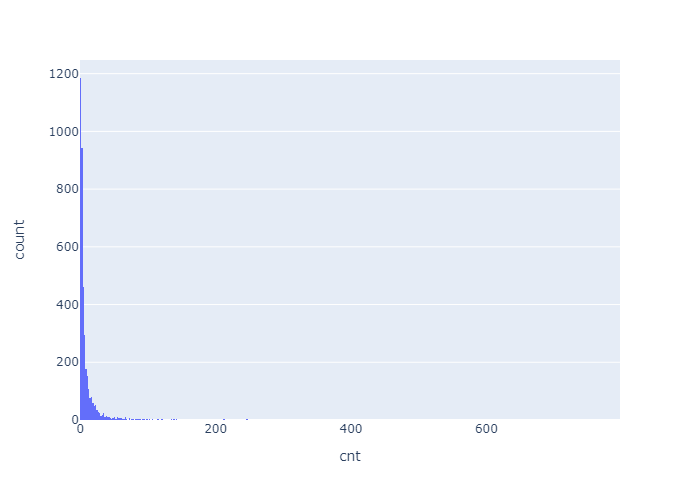

In [12]:
# Посмотрим на распределение количества покупок.
fig = px.histogram(frame, x='cnt')
fig.show('png')

Из графика видно, что распределение имеет экспоненциальный характер. При этом выбросы с правой стороны имеют очень высокие значения, что говорит о нецелесообразности использования средней для определения минимальной границы для рекомендаций.

Для определения минимальной границы было бы логично использовать медиану, но так как непопулярных комбинаций курсов крайне много, я решила остановиться на 60% квантиле, значение которого равно 5.

Для выведения списка курсов, которые будут случайным образом выдаваться в качестве рекомендаций, я решила, на основании переписки с продакт-менеджером, взять топ 5% пар курсов (95% квантиль) по количеству продаж (все-таки нас интересуют самые популярные курсы).

In [13]:
print(frame.cnt.quantile(0.60))
print(frame.cnt.quantile(0.95))

5.0
37.59999999999991


In [14]:
low_value = frame.cnt.quantile(0.60)

# Для выбора курсов для рекомендаций выбираем курсы только из самых продаваемых комбинаций (топ 5%).
courses_1 = frame[frame.cnt > frame.cnt.quantile(0.95)].course_1.to_list()
courses_2 = frame[frame.cnt > frame.cnt.quantile(0.95)].course_2.to_list()

# Создаем список с уникальными значениями курсов
# (именно список, так как функция random.choice, которую мы будем впоследствии использовать, некорректно работает со множествами).
best_courses = list(set(courses_1).union(set(courses_2)))
print('Количестово курсов, которые будут выдаваться в качестве рекомендаций:', len(best_courses))

Количестово курсов, которые будут выдаваться в качестве рекомендаций: 63


In [15]:
# Создадим таблицу, в которую будем заносить рекомендации.
recommendation_table = pd.DataFrame(df_final.course_id.unique(), columns=['course_id'])
recommendation_table.head()

,course_id
0,356
1,515
2,566
3,679
4,551


In [16]:
# Делаем функцию для первой рекомендации.
def first_recommendation(id):
    for i in range(frame.shape[0]):
        # Проверяем, находится ли id курса в комбинациях и превышает ли количество покупок минимальную границу для рекомендаций.  
        if id in frame.combos[i] and frame.cnt[i] > low_value:
            # Далее смотрим на какой позиции в кортеже находится курс и выдаем в рекомендацию его пару из кортежа.
            if id == frame.combos[i][0]:
                return frame.combos[i][1]
            elif id == frame.combos[i][1]:
                return frame.combos[i][0]
        # Если количество покупок менее или равно минимальной границе, то выдаем случайный курс из списка best_courses.
        elif id in frame.combos[i] and frame.cnt[i] <= low_value:
            return random.choice(best_courses)

In [17]:
# Делаем функцию для второй рекомендации.
# Функция аналогична пердыдущей с той лишь разницей, что идет проверка со столбцом с первой рекомендацией,
# чтобы случайно не выдавались одинаковые значения.
 
def second_recommendation(id):
    index = recommendation_table.index[recommendation_table['course_id'] == id][0]
    for i in range(frame.shape[0]):
        if id in frame.combos[i] and frame.cnt[i] > low_value:
            if id == frame.combos[i][0] and recommendation_table.loc[index, 'first_recommendation'] != frame.combos[i][1]:
                return frame.combos[i][1]
            elif id == frame.combos[i][1] and recommendation_table.loc[index, 'first_recommendation'] != frame.combos[i][0]:
                return frame.combos[i][0]
        elif id in frame.combos[i] and frame.cnt[i] <= low_value:
            rnd = random.choice(best_courses)
            if recommendation_table.loc[index, 'first_recommendation'] != rnd:
                return rnd
            else:
                return second_recommendation(id)

In [18]:
# Применяем написанные функции.
recommendation_table['first_recommendation'] = recommendation_table.course_id.apply(first_recommendation)
recommendation_table['second_recommendation'] = recommendation_table.course_id.apply(second_recommendation)
recommendation_table

,course_id,first_recommendation,second_recommendation
0,356,571,357
1,515,551,489
2,566,551,794
3,679,551,489
4,551,566,515
...,...,...,...
121,1182,809,502
122,865,829,1103
123,866,753,752
124,1200,777,489


В итоге мы получили таблицу с рекомендациями, которая состоит из 3х столбцов:
1. Курс, к которому идет рекомендация;
2. Первая рекомендация (самая популярная);
3. Вторая рекомендация (вторая по популярности).

Для всех курсов, которые не проходили по частоте продаж (от 5-ти и ниже), случайным образом рекомендуется курс из списка курсов с наибольшими количествами продаж. 

In [19]:
# Код для самопроверки, показывающий топ две комбинации для какого-либо курса
id = 356
frame[(frame.course_1 == id) | (frame.course_2 == id)].nlargest(2, columns='cnt')

,combos,course_1,course_2,cnt
48,"(356, 571)",356,571,103
50,"(356, 357)",356,357,100


### Тестирование гипотезы

Спустя месяц на сайте появляется новая функциональность — та самая, в подготовке которой мы участвовали. Теперь пользователи могут получать предложения добавить в корзину ещё курсы, которые могли бы им подойти.

Но прежде чем раскатывать рекомендательную систему на всех пользователей, коллеги хотят оценить эффективность этой функции и качество подбора рекомендаций и запускают для этого сплит-тест.

#### Запуск A/B-теста:
Все клиенты случайным образом делятся на контрольную и тестовую группы: тестовой группе показываются рекомендации, а контрольной — нет.

**До реализации рекомендаций средняя конверсия в покупку второго курса была 3,2%. Ожидается, что ввод рекомендаций сможет поднять её до 4%.**

Определим минимальный размер выборки для проведения теста при уровне достоверности 95% и статистической мощности 80%. Для расчёта воспользуемся [онлайн-калькулятором](https://www.evanmiller.org/ab-testing/sample-size.html).

![A/B test group count. Если картинка отображается некорректно, перезагрузите страницу.](https://drive.google.com/uc?id=1cgl16d0M4G2i0fZ6dhLhY1PRMzV86QbT)

*Прошло три недели...*

Каждый из вариантов A/B-теста достиг необходимого размера выборки, и теперь необходимо сделать вывод, можно ли считать реализацию рекомендательной системы успешной, и принять решение о полезности её внедрения. Для этого нужно посчитать ***p-value***. 

**Оценка результатов:** <br>
Численное выражение полученных результатов таково:

- В контрольной группе оказалось **8732 клиента**, оформивших заказ, из них **293 купили** больше одного курса.
- В тестовой — **8847 клиентов**, из них **347 купили** больше одного курса.

Для расчёта воспользуемся [онлайн-калькулятором](https://abtestguide.com/calc/).

![Test results. Если картинка отображается некорректно, перезагрузите страницу.](https://drive.google.com/uc?id=13VJz0NEekskbmmzrma1htqvNluN7fiNe)

In [20]:
p_value = 0.022
alpha = 0.05
p_value < alpha

True

Порог значимости равен 0,05, а p-значение – 0,022. Т. к. установленное значение альфа больше p-уровня, делаем вывод, что это статистически значимый результат.